<p align="center">
  <img src="img/richmond_civic_cover.jpg" alt="bart_analysis_cover" title="bart_analysis_cover">
</p>

## Overview

This analysis explores the **trip duration and routing patterns** between the **BART Richmond (RICH)** and **Civic Center (CIVC)** stations. Utilizing BART's public API, I aim to:

- **Assess average trip durations** between these stations.
- **Identify common transfer stations** and routes.
- **Visualize temporal patterns** in trip schedules.

## Data Source

Data is sourced from the [BART API](https://api.bart.gov), which provides scheduled trip information. The API returns data in JSON format, detailing trip times, routes, and transfer stations.


<p align="center">
  <img src="img/BART_system_map.png" alt="bart_analysis_cover" title="bart_analysis_cover">
</p>
<p align="center">
BART system map 2025
</p>

## Methodology

1. **API Request**: Construct a URL to fetch scheduled trips between Richmond and Civic Center.
2. **Data Extraction**: Parse the JSON response to extract relevant trip details.
3. **Data Analysis**:
   - Calculate the trip durations.
   - Identify common transfer stations.
4. **Visualization**: Create plots to visualize trip durations and transfer patterns.

## Analysis Steps

In [ ]:
!pip install requests
!pip install pandas
!pip install plotly

### 1. Fetching Scheduled Trip Data

In [ ]:
# sends a request to the bart api to fetch trip schedules 
# between richmond (rich) and civic center (civc), then parses the 
# response into json format for further analysis.

import requests

API_KEY = 'QV8D-PY9K-9LMT-DWEI'
ORIG = 'RICH'
DEST = 'CIVC' 
url = f"https://api.bart.gov/api/sched.aspx?cmd=arrive&orig={ORIG}&dest={DEST}&date=now&key={API_KEY}&b=2&a=2&l=1&json=y"
print(url)

response = requests.get(url)
print(f"Status Code: {response.status_code}")

json_data = response.json()


https://api.bart.gov/api/sched.aspx?cmd=arrive&orig=RICH&dest=CIVC&date=now&key=QV8D-PY9K-9LMT-DWEI&b=2&a=2&l=1&json=y
Status Code: 200


###2. Parsing and Analyzing Trip Data

#### 2.1 Extract Trip Information

In [ ]:
# flattens the json data into a pandas dataframe for easier manipulation

import pandas as pd
df = pd.json_normalize(json_data)
print(df.shape)
# df


(1, 12)


In [ ]:
# import json
# print(json.dumps(json_data, indent=2))

#### 2.2 Normalize Trip Data

In [ ]:
# extracts the trip details from the json response and normalizes them into a structured dataframe.

trips = json_data['root']['schedule']['request']['trip']

df_trips = pd.json_normalize(trips)
# df_trips


#### 2.3 Extract Leg Information

In [ ]:
# expands each trip into its individual legs and creates a dataframe with detailed segment information.

legs_df = pd.json_normalize(
            trips,
            record_path=['leg'],
)
legs_df

,@order,@origin,@destination,@origTimeMin,@origTimeDate,@destTimeMin,@destTimeDate,@originPlatform,@destinationPlatform,@line,@bikeflag,@trainHeadStation,@load
0,1,RICH,MCAR,07:43 AM,09/17/2025,08:01 AM,09/17/2025,PL 2,PL 2,ROUTE 4,1,OAK Airport / Berryessa/North San Jose,0
1,2,MCAR,CIVC,08:02 AM,09/17/2025,08:24 AM,09/17/2025,PL 4,PL 1,ROUTE 1,1,San Francisco International Airport,0
2,1,RICH,CIVC,07:50 AM,09/17/2025,08:31 AM,09/17/2025,PL 2,PL 1,ROUTE 7,1,SF / SFO Airport / Millbrae,0
3,1,RICH,MCAR,08:03 AM,09/17/2025,08:21 AM,09/17/2025,PL 2,PL 2,ROUTE 4,1,OAK Airport / Berryessa/North San Jose,0
4,2,MCAR,CIVC,08:22 AM,09/17/2025,08:44 AM,09/17/2025,PL 4,PL 1,ROUTE 1,1,San Francisco International Airport,0
5,1,RICH,CIVC,08:10 AM,09/17/2025,08:51 AM,09/17/2025,PL 2,PL 1,ROUTE 7,1,SF / SFO Airport / Millbrae,0


### 3. Data Processing

#### 3.1 Convert Times and Calculate Durations

In [ ]:
# converts time columns to datetime format, calculates trip leg durations, and adds duration in minutes.

legs_df['@origTimeMin'] = pd.to_datetime(legs_df['@origTimeMin'])
legs_df['@destTimeMin'] = pd.to_datetime(legs_df['@destTimeMin'])

legs_df['duration'] = legs_df['@destTimeMin'] - legs_df['@origTimeMin']
legs_df['duration_min'] = legs_df['duration'].dt.total_seconds() / 60

legs_df

,@order,@origin,@destination,@origTimeMin,@origTimeDate,@destTimeMin,@destTimeDate,@originPlatform,@destinationPlatform,@line,@bikeflag,@trainHeadStation,@load,duration,duration_min
0,1,RICH,MCAR,2025-09-17 07:43:00,09/17/2025,2025-09-17 08:01:00,09/17/2025,PL 2,PL 2,ROUTE 4,1,OAK Airport / Berryessa/North San Jose,0,0 days 00:18:00,18.0
1,2,MCAR,CIVC,2025-09-17 08:02:00,09/17/2025,2025-09-17 08:24:00,09/17/2025,PL 4,PL 1,ROUTE 1,1,San Francisco International Airport,0,0 days 00:22:00,22.0
2,1,RICH,CIVC,2025-09-17 07:50:00,09/17/2025,2025-09-17 08:31:00,09/17/2025,PL 2,PL 1,ROUTE 7,1,SF / SFO Airport / Millbrae,0,0 days 00:41:00,41.0
3,1,RICH,MCAR,2025-09-17 08:03:00,09/17/2025,2025-09-17 08:21:00,09/17/2025,PL 2,PL 2,ROUTE 4,1,OAK Airport / Berryessa/North San Jose,0,0 days 00:18:00,18.0
4,2,MCAR,CIVC,2025-09-17 08:22:00,09/17/2025,2025-09-17 08:44:00,09/17/2025,PL 4,PL 1,ROUTE 1,1,San Francisco International Airport,0,0 days 00:22:00,22.0
5,1,RICH,CIVC,2025-09-17 08:10:00,09/17/2025,2025-09-17 08:51:00,09/17/2025,PL 2,PL 1,ROUTE 7,1,SF / SFO Airport / Millbrae,0,0 days 00:41:00,41.0


#### 3.2 Assign Trip IDs

In [ ]:
# assigns a unique trip id to each sequence of connected legs by checking if the origin matches the previous leg's destination.

trip_id = 0
trip_ids = []

for i, row in legs_df.iterrows():
    if i == 0:
        trip_id += 1
    else:
        prev = legs_df.iloc[i-1]
        # start new trip if current leg doesn't continue from previous leg
        if row['@origin'] != prev['@destination']:
            trip_id += 1
    trip_ids.append(trip_id)
    
legs_df['trip_id'] = trip_ids

legs_df

,@order,@origin,@destination,@origTimeMin,@origTimeDate,@destTimeMin,@destTimeDate,@originPlatform,@destinationPlatform,@line,@bikeflag,@trainHeadStation,@load,duration,duration_min,trip_id
0,1,RICH,MCAR,2025-09-17 07:43:00,09/17/2025,2025-09-17 08:01:00,09/17/2025,PL 2,PL 2,ROUTE 4,1,OAK Airport / Berryessa/North San Jose,0,0 days 00:18:00,18.0,1
1,2,MCAR,CIVC,2025-09-17 08:02:00,09/17/2025,2025-09-17 08:24:00,09/17/2025,PL 4,PL 1,ROUTE 1,1,San Francisco International Airport,0,0 days 00:22:00,22.0,1
2,1,RICH,CIVC,2025-09-17 07:50:00,09/17/2025,2025-09-17 08:31:00,09/17/2025,PL 2,PL 1,ROUTE 7,1,SF / SFO Airport / Millbrae,0,0 days 00:41:00,41.0,2
3,1,RICH,MCAR,2025-09-17 08:03:00,09/17/2025,2025-09-17 08:21:00,09/17/2025,PL 2,PL 2,ROUTE 4,1,OAK Airport / Berryessa/North San Jose,0,0 days 00:18:00,18.0,3
4,2,MCAR,CIVC,2025-09-17 08:22:00,09/17/2025,2025-09-17 08:44:00,09/17/2025,PL 4,PL 1,ROUTE 1,1,San Francisco International Airport,0,0 days 00:22:00,22.0,3
5,1,RICH,CIVC,2025-09-17 08:10:00,09/17/2025,2025-09-17 08:51:00,09/17/2025,PL 2,PL 1,ROUTE 7,1,SF / SFO Airport / Millbrae,0,0 days 00:41:00,41.0,4


#### 3.3 Aggregate Routes and Calculate Average Duration

In [10]:
# groups legs by trip id to calculate full routes and merges the results back to the legs dataframe.
# computes the average trip duration across all routes.

routes_df = (
    legs_df.groupby("trip_id")
    .agg(
        route_origin=("@origin", "first"),
        route_destination=("@destination", "last"),
        total_duration=("duration_min", "sum")
        )
    .reset_index()
)

legs_df = legs_df.merge(routes_df, on="trip_id", how="left")

avg_duration = routes_df['total_duration'].mean()
print('avg_duration', avg_duration)

legs_df

avg_duration 40.5


,@order,@origin,@destination,@origTimeMin,@origTimeDate,@destTimeMin,@destTimeDate,@originPlatform,@destinationPlatform,@line,@bikeflag,@trainHeadStation,@load,duration,duration_min,trip_id,route_origin,route_destination,total_duration
0,1,RICH,MCAR,2025-09-17 07:43:00,09/17/2025,2025-09-17 08:01:00,09/17/2025,PL 2,PL 2,ROUTE 4,1,OAK Airport / Berryessa/North San Jose,0,0 days 00:18:00,18.0,1,RICH,CIVC,40.0
1,2,MCAR,CIVC,2025-09-17 08:02:00,09/17/2025,2025-09-17 08:24:00,09/17/2025,PL 4,PL 1,ROUTE 1,1,San Francisco International Airport,0,0 days 00:22:00,22.0,1,RICH,CIVC,40.0
2,1,RICH,CIVC,2025-09-17 07:50:00,09/17/2025,2025-09-17 08:31:00,09/17/2025,PL 2,PL 1,ROUTE 7,1,SF / SFO Airport / Millbrae,0,0 days 00:41:00,41.0,2,RICH,CIVC,41.0
3,1,RICH,MCAR,2025-09-17 08:03:00,09/17/2025,2025-09-17 08:21:00,09/17/2025,PL 2,PL 2,ROUTE 4,1,OAK Airport / Berryessa/North San Jose,0,0 days 00:18:00,18.0,3,RICH,CIVC,40.0
4,2,MCAR,CIVC,2025-09-17 08:22:00,09/17/2025,2025-09-17 08:44:00,09/17/2025,PL 4,PL 1,ROUTE 1,1,San Francisco International Airport,0,0 days 00:22:00,22.0,3,RICH,CIVC,40.0
5,1,RICH,CIVC,2025-09-17 08:10:00,09/17/2025,2025-09-17 08:51:00,09/17/2025,PL 2,PL 1,ROUTE 7,1,SF / SFO Airport / Millbrae,0,0 days 00:41:00,41.0,4,RICH,CIVC,41.0


### 4. Visualizing the Results

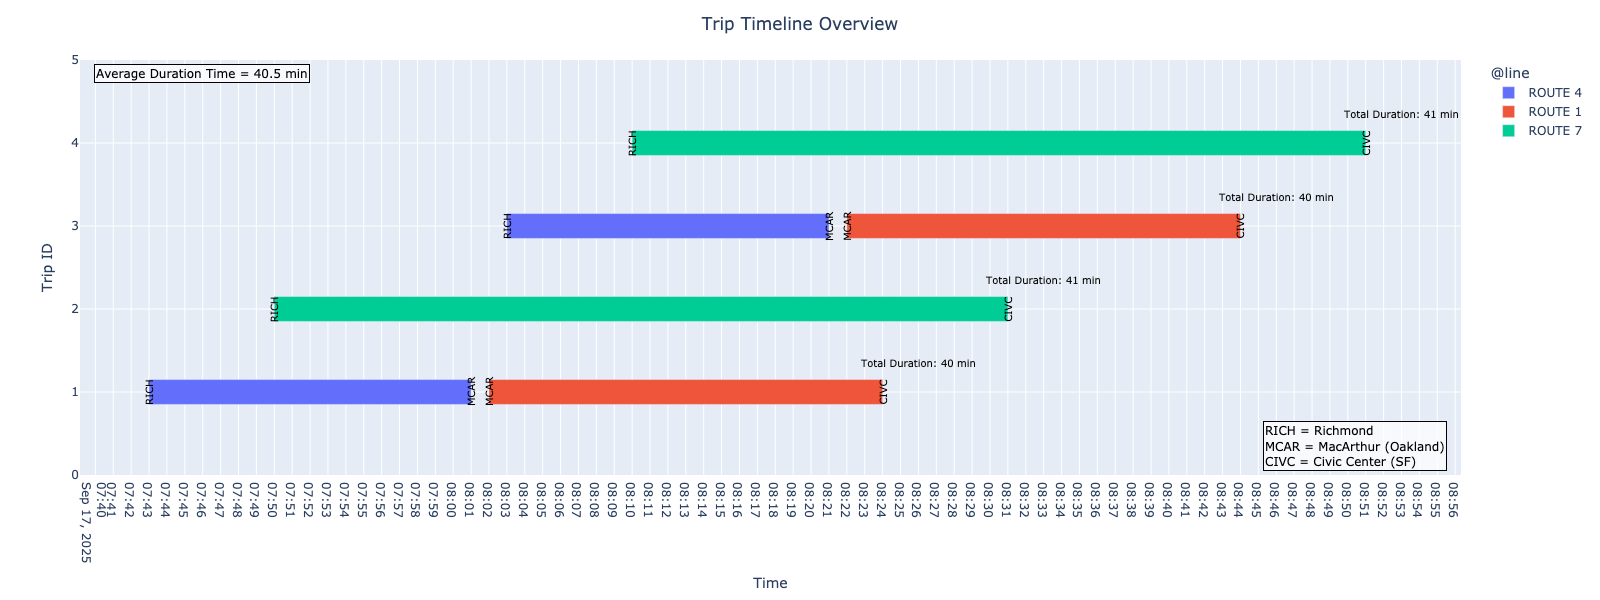

In [13]:
import plotly.express as px

import plotly.io as pio
# pio.renderers.default = "png"

png_renderer = pio.renderers["png"]
png_renderer.width = 1600
png_renderer.height = 600

# timeline
fig = px.timeline(
    legs_df,
    x_start='@origTimeMin',
    x_end='@destTimeMin',
    y='trip_id',
    color='@line',
)

# bar thickness
fig.update_traces(width=0.3)

# origin/ destination labels
for i, row in legs_df.iterrows():
    # origin label
    fig.add_annotation(
        x=row['@origTimeMin'],
        y=row['trip_id'],
        text=row['@origin'],
        showarrow=False,
        xanchor='center',
        yanchor='middle',
        textangle=-90,
        font=dict(size=10, color="black")
    )
    # destination label
    fig.add_annotation(
        x=row['@destTimeMin'],
        y=row['trip_id'],
        text=row['@destination'],
        showarrow=False,
        xanchor='center',
        yanchor='middle',
        textangle=-90,
        font=dict(size=10, color="black")
    )

# total duration label
for trip_id, total_duration in legs_df.groupby('trip_id')['total_duration'].first().items():
    
    end_time = legs_df.loc[legs_df['trip_id'] == trip_id, '@destTimeMin'].max()
    
    fig.add_annotation(
        x=end_time + pd.Timedelta(minutes=2),
        y=trip_id + 0.35,
        text=f"Total Duration: {total_duration:.0f} min",
        showarrow=False,
        font=dict(size=10, color="black"),
        align="left"
    )

# average duration
fig.add_annotation(
    xref="paper",
    yref="paper",
    x=0.01,        
    y=0.99,
    text=f"Average Duration Time = {avg_duration:.1f} min",
    showarrow=False,
    font=dict(size=12, color="black"),
    align="left",
    bgcolor="rgba(255,255,255,0.7)",
    bordercolor="black",
    borderwidth=1
)

# stations
fig.add_annotation(
    xref="paper",
    yref="paper",
    x=0.99,   
    y=0.01, 
    text="RICH = Richmond<br>MCAR = MacArthur (Oakland)<br>CIVC = Civic Center (SF)",
    showarrow=False,
    font=dict(size=12, color="black"),
    align="left",
    bgcolor="rgba(255,255,255,0.7)",
    bordercolor="black",
    borderwidth=1
)

# gridlines
fig.update_xaxes(
    title='Time',
    showgrid=True,
    dtick=1*60*1000
)
fig.update_yaxes(title='Trip ID', showgrid=True)

fig.update_layout(
    title="Trip Timeline Overview",
    title_x=0.5
)

fig.show(renderer="png")

## Summary of Findings
- Trips are either direct from **Richmond (RICH) to Civic Center (CIVC)** or involve a transfer at **MacArthur (MCAR)**, yet travel times remain similar across both options.
- Most trips last about **40–41** minutes, with an average of **40.5** minutes, which reflects a strong schedule consistency.
- Trips are staggered every **~10** minutes between 13:50 and 15:00, which shows an even distribution.



### Some notes:
- The analysis could help identify the most critical path, especially in situations with multiple scheduling alternatives.
- By analyzing the time gaps or breaks between trips, it's possible to optimize trip schedules and overall operations.
- Tracking this data over time allows us to create a baseline, which can be used to analyze and compare any new trips against the historical average.
